In [19]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import TimeSeriesSplit

In [9]:
config = {
    "alpha_vantage": {
        "key": "KNKL5W59B6K6W1LD",
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "data": {
        "window_size": 100,
        "train_split_size": 0.9,
    }, 
    "plots": {
        "xticks_interval": 500, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.0001,
        "scheduler_step_size": 40,
    },
    "csv":{
        "file_name": "AAPL.csv",
    }
}

config_rand = []

for i in range(100):
    config_rand += [float(random.randrange(0,100))]


In [3]:
df = pd.read_csv("BTC-USDclose.csv")



In [4]:
df.head()

,Date,Close
0,01/01/2017,998.325012
1,02/01/2017,1021.750000
2,03/01/2017,1043.839966
3,04/01/2017,1154.729980
4,05/01/2017,1013.380005


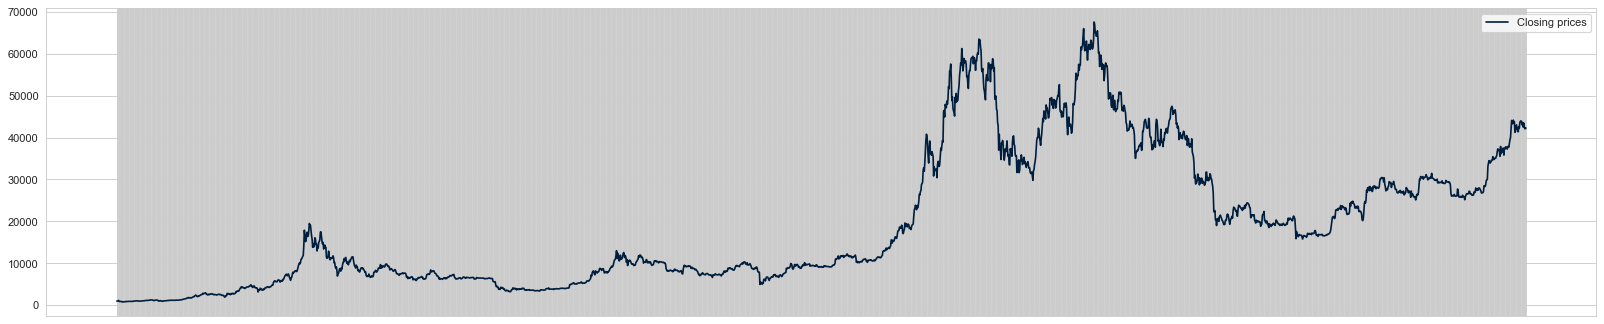

In [68]:
num_data_points = len(df['Date'])
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.tick_params(
    axis='x',      
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.plot(df['Date'], df['Close'], label="Closing prices", color=config["plots"]["color_actual"])
xticks = [df['Date'][i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)]
plt.legend()
plt.show()


In [17]:
len(df['Date']) 

2556

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

<Figure size 2000x400 with 0 Axes>

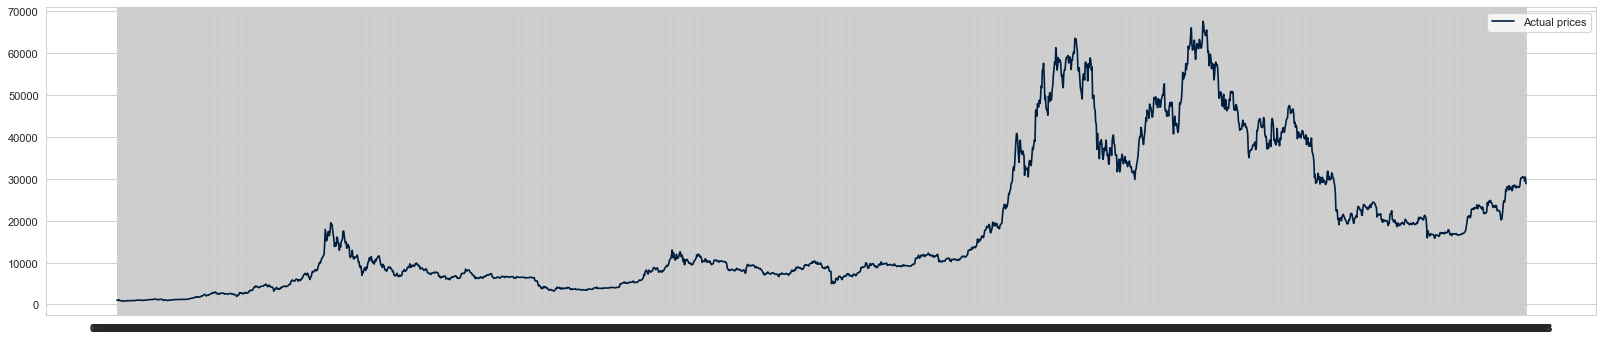

In [23]:

num_data_points = len(df_train['Date'])
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(df_train['Date'], df_train['Close'], label="Actual prices", color=config["plots"]["color_actual"])
xticks = [df_train['Date'][i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)]
plt.legend()
plt.show()


In [36]:
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

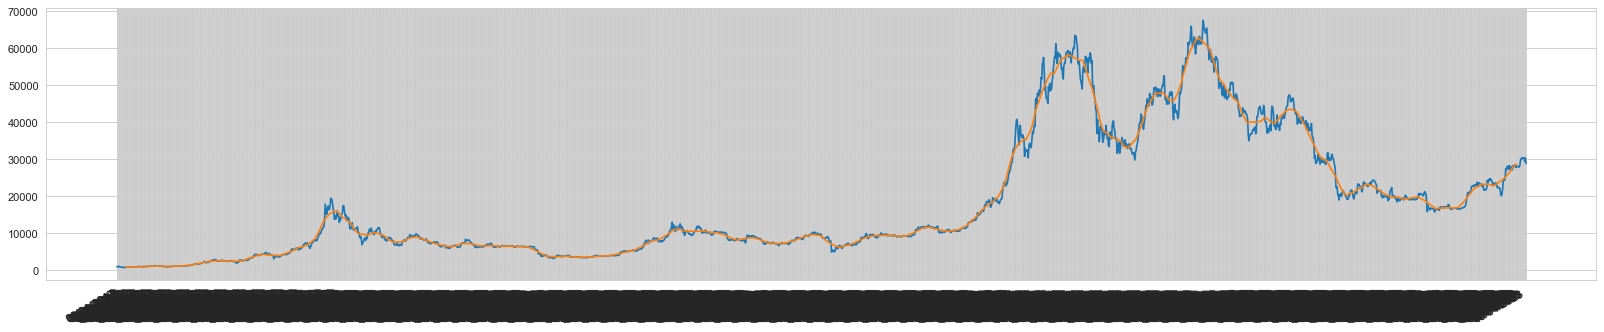

In [38]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(df_train.Date, df_train.Close)
plt.plot(df_train.Date.iloc[15:-15], df_train.Close.rolling(30).mean().iloc[30:])
plt.gcf().autofmt_xdate()

plt.show()

In [52]:
from sklearn.linear_model import LinearRegression

train_times = df_train.index.values
cosines = np.stack([np.cos((2+i)*np.pi*train_times/256) for i in range(20)]  , axis = 1)
sines = np.stack([np.sin((2+i)*np.pi*train_times/256) for i in range(20)]  , axis = 1)
train_features = np.concatenate([train_times.reshape(-1,1), cosines, sines], axis = 1)

lr = LinearRegression()
lr.fit(train_features,df_train.Close)

LinearRegression()

In [53]:
lr_train_preds = lr.predict(train_features)
lr_train_res = df_train.Close - lr_train_preds

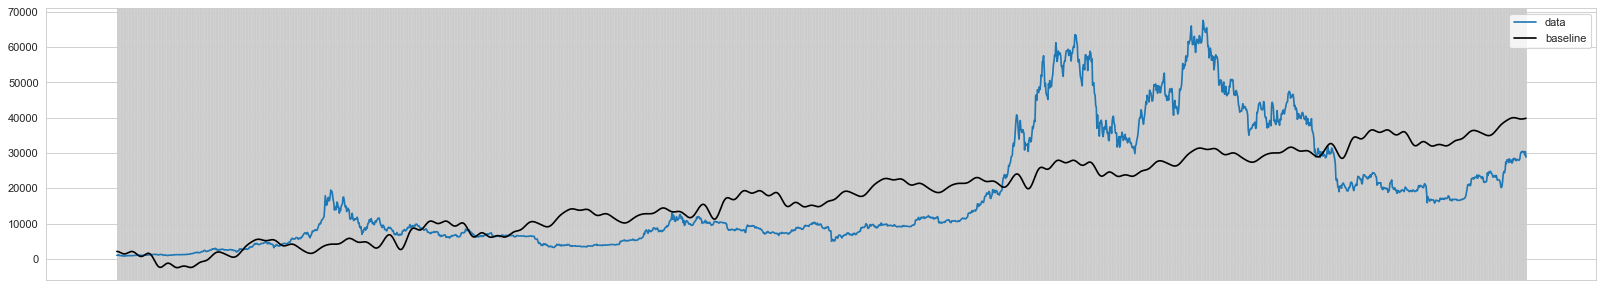

In [66]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
fig.set_facecolor('white')
plt.tick_params(
    axis='x',      
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.plot(df_train.Date, df_train.Close, label = 'data')
plt.plot(df_train.Date, lr_train_preds, 'k',label = 'baseline')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [55]:
sarima = sm.ARIMA(df_train.Close, exog = train_features, order=(1, 0, 0), seasonal_order=(0, 1, 1, 14))
 
fitted_sarima = sarima.fit()

In [57]:
sarima_train_preds = fitted_sarima.fittedvalues

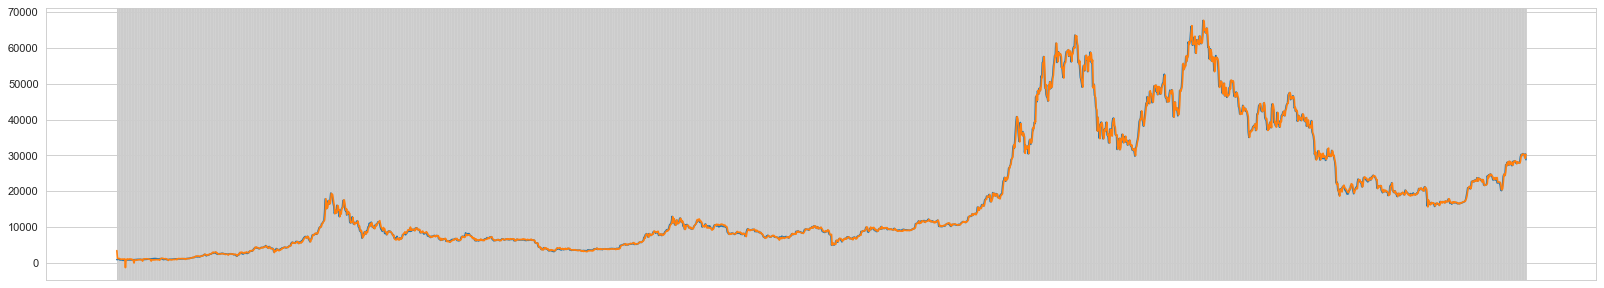

In [69]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.tick_params(
    axis='x',      
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.plot(df_train.Date, df_train.Close)
plt.plot(df_train.Date, sarima_train_preds)
plt.gcf().autofmt_xdate()

plt.show()

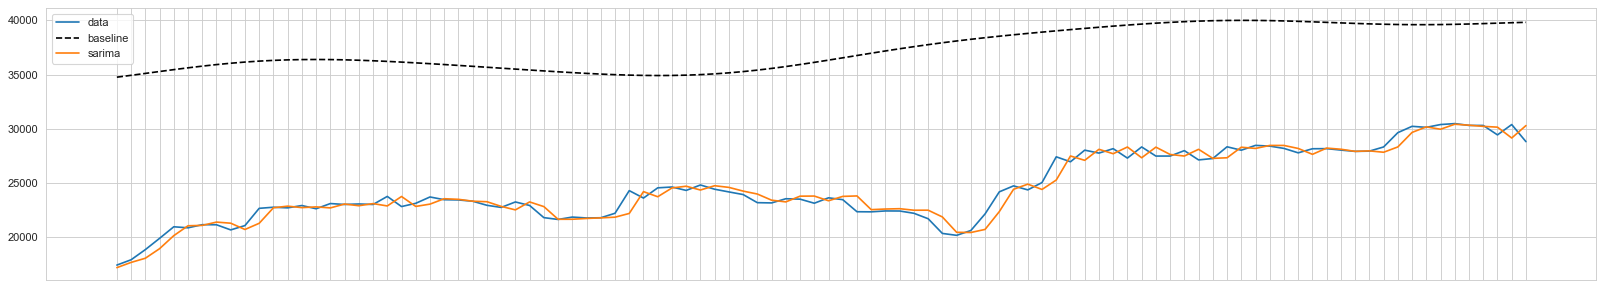

In [70]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.tick_params(
    axis='x',      
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.plot(df_train.Date.iloc[-100:], df_train.Close.iloc[-100:], label = 'data')
plt.plot(df_train.Date.iloc[-100:], lr_train_preds[-100:], '--k',label = 'baseline')
plt.plot(df_train.Date.iloc[-100:], sarima_train_preds[-100:], label = 'sarima')
plt.gcf().autofmt_xdate()

plt.legend()

plt.show()

In [50]:
from sklearn.metrics import mean_squared_error

In [60]:
# Making the baseline prediction and arima prediction on the testing data.

test_times = df_test.index.values
test_features = np.concatenate([test_times.reshape(-1,1), cosines[:256,:], sines[:256,:]], axis = 1)

sarima_test_preds = fitted_sarima.forecast(256, exog = test_features)
lr_test_preds = lr.predict(test_features)


In [61]:
mean_squared_error(df_test.Close,lr_test_preds)

92421284.17249326

In [62]:
mean_squared_error(df_test.Close, sarima_test_preds)

23655937.53838784